In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import entropy
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import jensenshannon
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Task 1

In [2]:
# reading images and converting to grayscale

image1 = cv2.imread('spiti_saturated.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('Spiti.jpg', cv2.IMREAD_GRAYSCALE)


#hist calculation 
histogram1 = cv2.calcHist([image1], [0], None, [256], [0, 256]).flatten()
histogram2 = cv2.calcHist([image2], [0], None, [256], [0, 256]).flatten()

#normalizing as pdf 
histogram1_normalized = histogram1 / np.sum(histogram1)
histogram2_normalized = histogram2 / np.sum(histogram2)

In [3]:
#histogram1_normalized

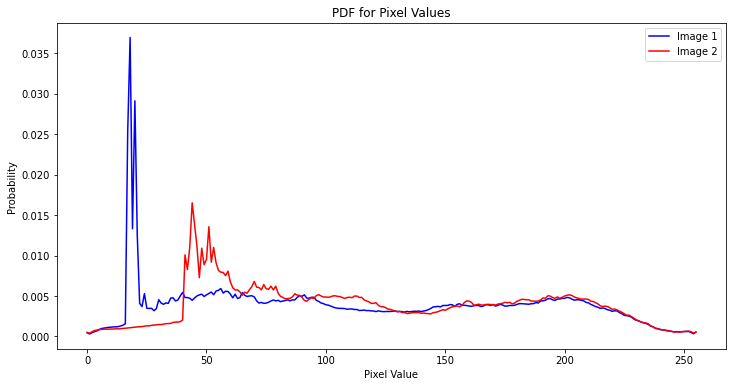

In [4]:
#plotting the plots
plt.figure(figsize=(12, 6))

plt.plot(histogram1_normalized, color='blue', label='Image 1')
plt.plot(histogram2_normalized, color='red', label='Image 2')

plt.title('PDF for Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Probability')
plt.legend()

plt.show()

In [5]:
# Kolmogorov-Smirnov test
ks_stat, ks_p = ks_2samp(histogram1_normalized, histogram2_normalized)

print(f'Kolmogorov-Smirnov statistic: {ks_stat}')

Kolmogorov-Smirnov statistic: 0.15625


In [132]:
# cross entropy
cross_entropy = cross_entropy = entropy(histogram1_normalized, histogram2_normalized) + entropy(histogram1_normalized)

print(f'Cross-Entropy: {cross_entropy}')

Cross-Entropy: 5.66406774520874


In [7]:
# KL Divergence
kl_div = entropy(histogram1_normalized, histogram2_normalized)

print(f'KL Divergence: {kl_div}')

KL Divergence: 0.32794955372810364


In [8]:
# JS Divergence
js_div = jensenshannon(histogram1_normalized, histogram2_normalized)**2  

print(f'JS Divergence: {js_div}')

JS Divergence: 0.04920138791203498


# Task 2

In [140]:
# defining parameters for clusters

means = [[0, 0, 0], [2, 2, 2], [-2, -2, -2]]
covariances = [np.eye(3) * 0.5, np.eye(3) * 1.0, np.eye(3) * 2.0]

points_p_cluster = 500
weights = np.array([0.3, 0.4, 0.3])
data = []
for i in range(3):
    data.append(np.random.multivariate_normal(means[i], covariances[i], points_p_cluster))


In [141]:
#data

In [142]:
data = np.concatenate(data)

In [143]:
#data.shape

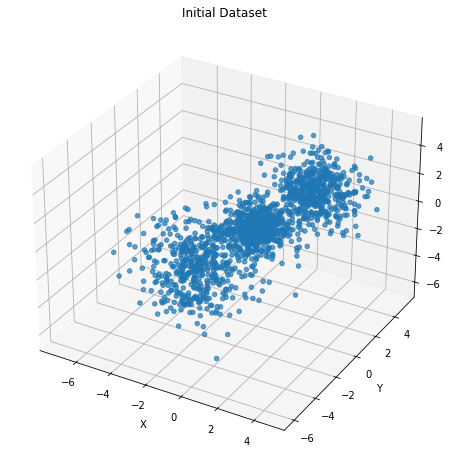

In [144]:
#plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], marker='o', alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Initial Dataset')
plt.show()

In [145]:
# maximisation step 
def m_step(X, gamma):
    N, K = X.shape[0], gamma.shape[1]
    d = X.shape[1]
    regularization_term = 1e-6
    Nk = np.sum(gamma, axis=0) + 10 * np.finfo(float).eps   
    
    means = np.dot(gamma.T, X) / Nk[:, np.newaxis]
    covs = []
    for k in range(K):
        diff = X - means[k]
        cov_k = np.dot(gamma[:, k] * diff.T, diff) / Nk[k] + np.eye(d) * regularization_term
        covs.append(cov_k)
    
    weights = Nk / np.sum(Nk)
    return means, np.array(covs), weights

In [146]:
#estimation step 
def e_step(X, means, covs, weights):
    N, K = X.shape[0], len(weights)
    gamma = np.zeros((N, K))
    for k in range(K):
        cov_k = covs[k] + np.eye(X.shape[1]) * 1e-6  
        rv = multivariate_normal(mean=means[k], cov=cov_k)
        gamma[:, k] = rv.pdf(X) * weights[k]
    gamma /= np.sum(gamma, axis=1, keepdims=True)
    return gamma

In [176]:
#visualising clusters
def visualize_clusters(X, gamma, means, title='GMM Clusters'):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection='3d')
    K = means.shape[0] 
    cmap = plt.get_cmap('magma', K)  

    cluster_assignments = np.argmax(gamma, axis=1)
    for k in range(K):
        cluster_data = X[cluster_assignments == k]
        ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], 
                    color=cmap(k), alpha=0.3, label=f'Cluster {k+1}')
    
    ax.scatter(means[:, 0], means[:, 1], means[:, 2], c='red', s=200, marker='X')

    ax.set_title(title)
    plt.legend()
    plt.show()


In [177]:
def run_em(X, K, max_iters=20):
    np.random.seed(42)
    random_indices = np.random.choice(X.shape[0], K, replace=False)
    means = X[random_indices]
    covs = np.array([np.eye(X.shape[1])] * K)
    weights = np.ones(K) / K 
    
    for i in range(1, max_iters + 1):  
        gamma = e_step(X, means, covs, weights)
        means, covs, weights = m_step(X, gamma)
        
        if 1 <= i <= 20: 
            visualize_clusters(X, gamma, means, title=f'Iteration {i}')


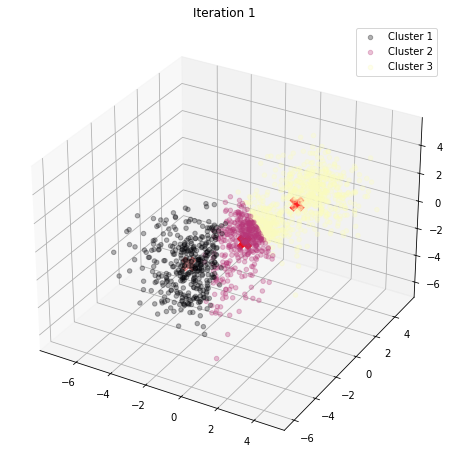

In [178]:
# K = number of clusters 
K = 3  
run_em(data, K, 1)

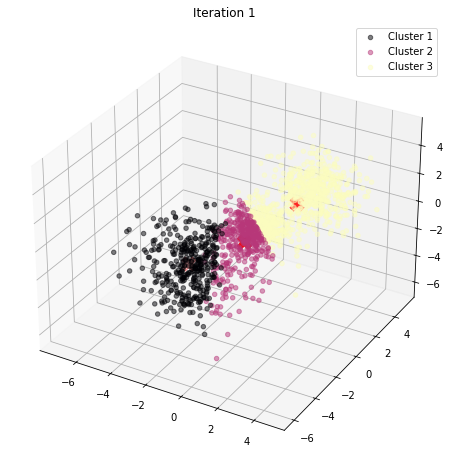

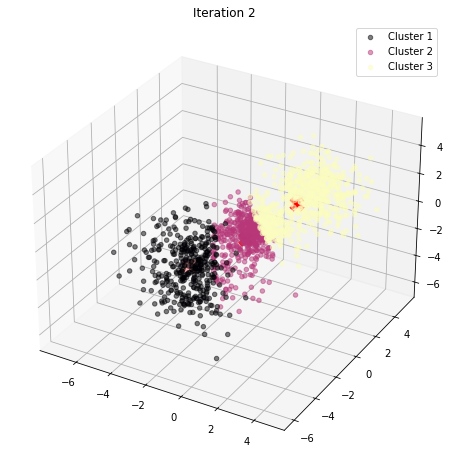

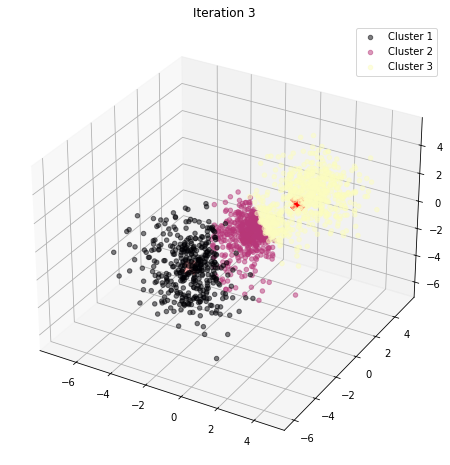

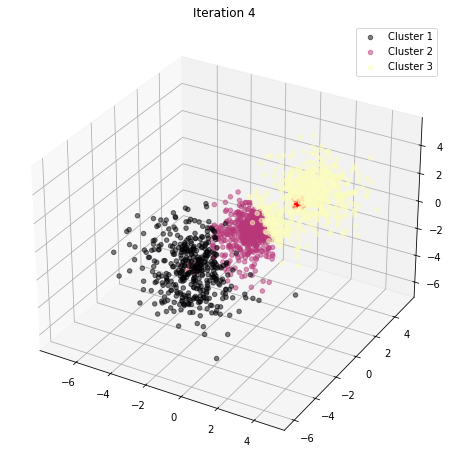

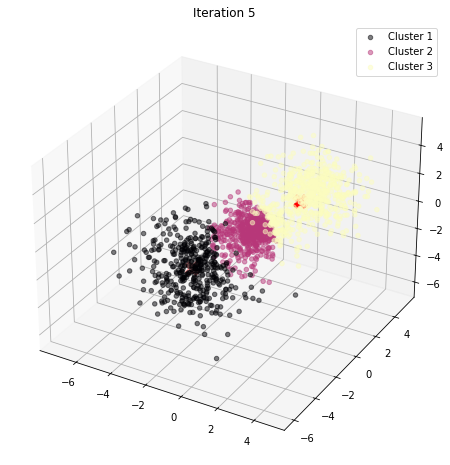

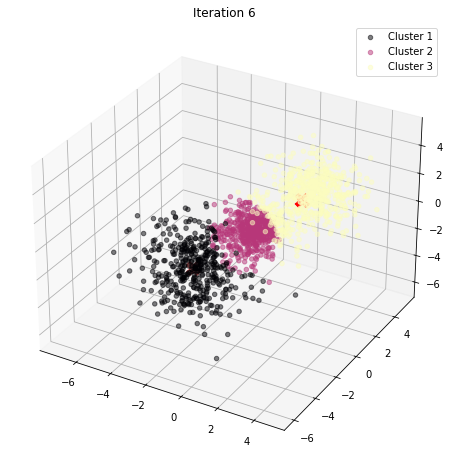

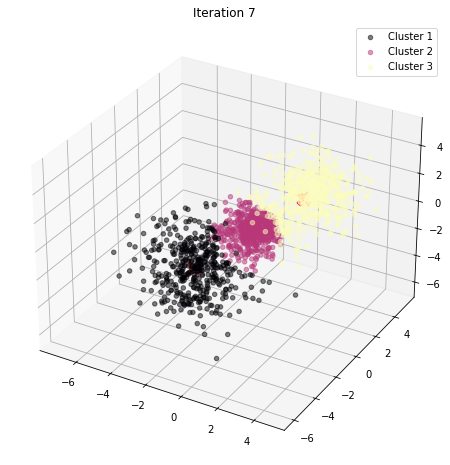

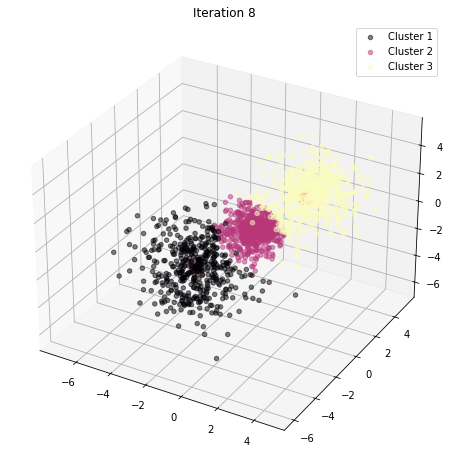

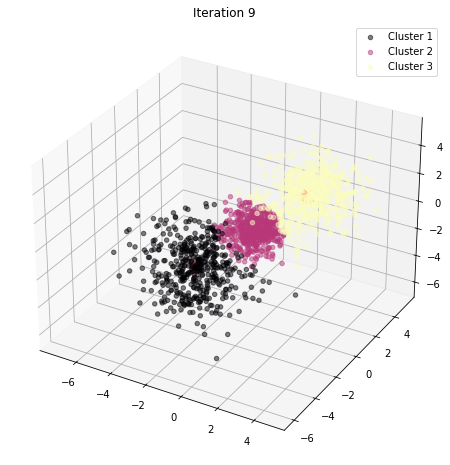

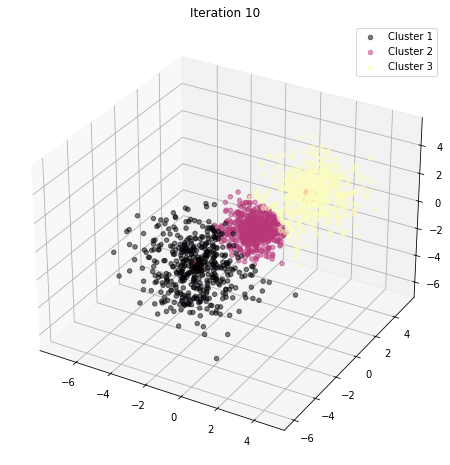

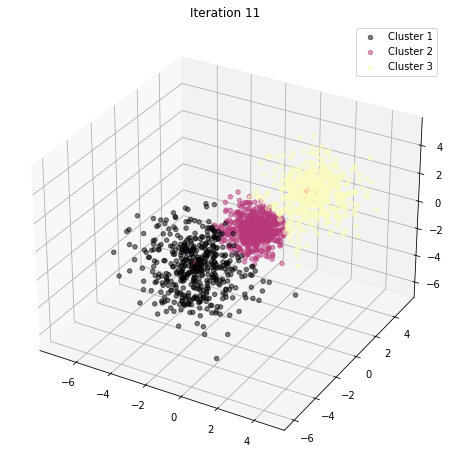

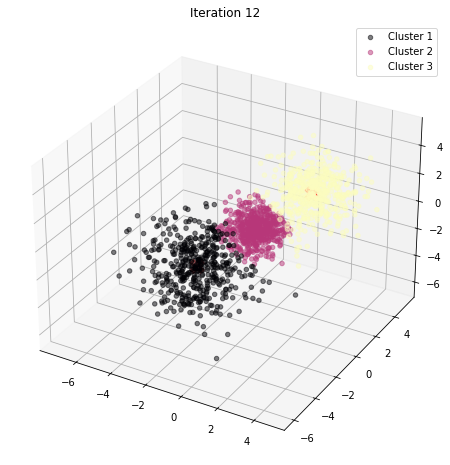

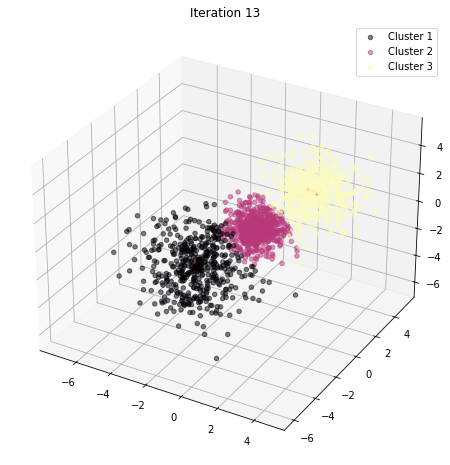

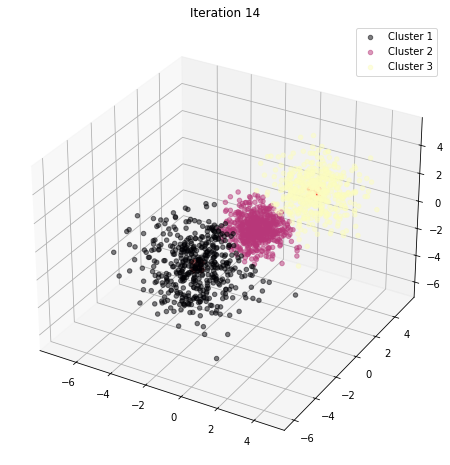

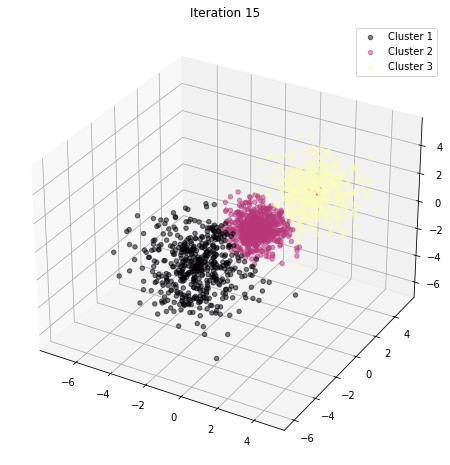

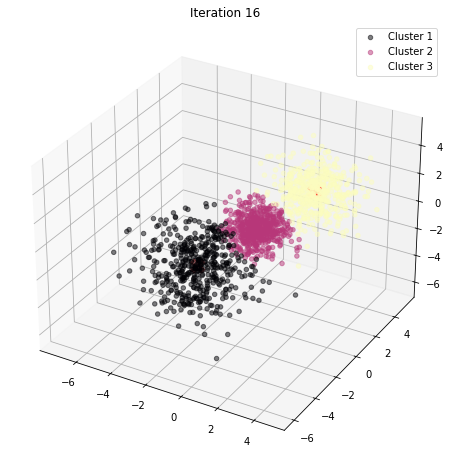

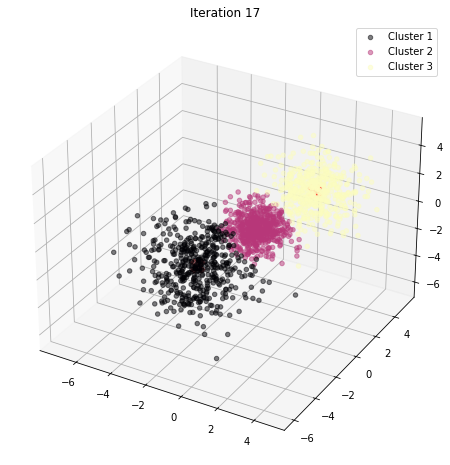

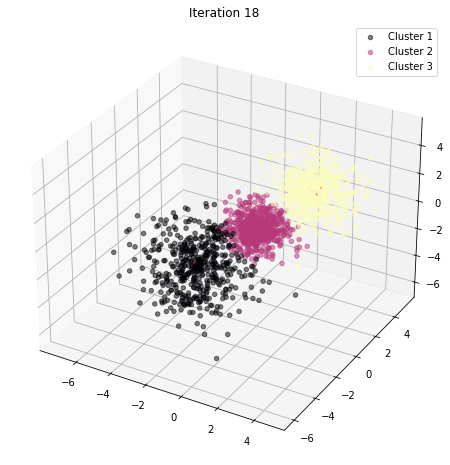

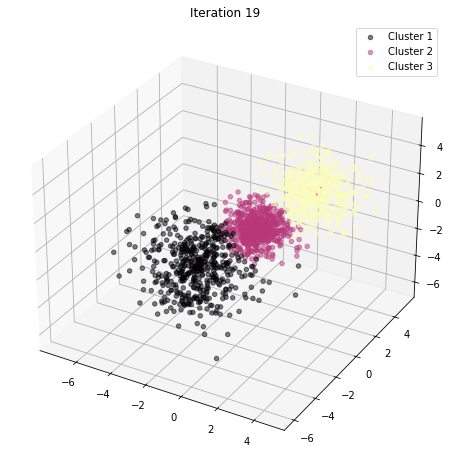

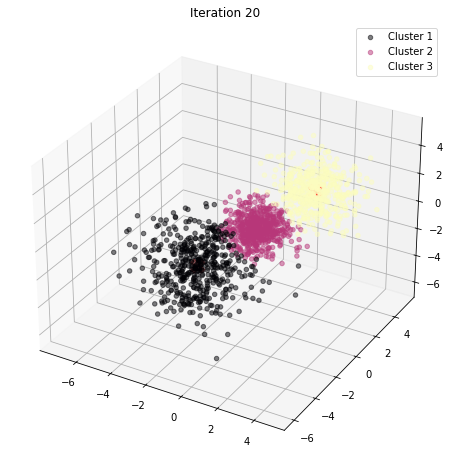

In [169]:
run_em(data, K, 20)